In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from ephys import *
from session_utils import find_all_sessions, make_df_all_sessions


## Load all session data

In [2]:
# Load pickled data
df_all_sessions = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')

# Load all session names and paths as dict
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')

# # TESTING Drop all but a single row
# session_dict = {k: session_dict[k] for k in list(session_dict)[10:11]}

df_all_sessions = make_df_all_sessions(session_dict, recording_type = 'nexus' )


    
# # Drop rows with no included clusters
# df_all_cells = df_all_cells.dropna()
# print(f'{len(df_all_cells.index)} sessions retained')

df_all_sessions.head()

,ephys_object
230503_r1354,<ephys.ephys object at 0x7f61645ca370>
230504_r1354,<ephys.ephys object at 0x7f61d804be50>
230505_r1354,<ephys.ephys object at 0x7f61d8064c10>
230506_r1354,<ephys.ephys object at 0x7f6113cd8c40>
230507_r1354,<ephys.ephys object at 0x7f6113cd8a30>


## Load theta phase and cycle for each trial

In [3]:
from analysis.get_theta_frequencies import get_theta_frequencies
from analysis.get_theta_phase import get_theta_phase

lfp_sampling_rate = 1000
# channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channels_to_load = [35] # From generate 5x12/16 probe script, corresponding to central shank @0um

# Loop through sessions
for row, obj in enumerate(df_all_sessions.loc[:, 'ephys_object']):
    
    # Initalise object attribute to store theta phase data
    obj.cycle_data = [{} for _ in range(len(obj.trial_list))]
    
    # Load theta phase info for all trials
    for trial_iterator, trial in enumerate(obj.trial_list):

        # Load LFP for trial from contact on central shank at 0um (channel 15 on the 5x12/16 Buz probe)
        obj.load_lfp(trial_iterator,
                        sampling_rate = lfp_sampling_rate, 
                        channels  = channels_to_load, 
                        reload_flag = True, ##CHANGE BACK IF NEEDED
                        scale_to_uv = False)
        
        # Find peak theta frequencies for channel @ 0um and make dict of {channel: theta_freq}
        theta_freqs = get_theta_frequencies(obj.lfp_data[trial_iterator]['data'], lfp_sampling_rate)
        theta_freqs = dict(zip(channels_to_load, theta_freqs))

        # Initialise theta phase array
        theta_phase = [None] * len(channels_to_load)
        cycle_numbers = [None] * len(channels_to_load)

        # Loop through each included channel
        for channel_iterator, channel in enumerate(channels_to_load):

            # Get peak theta frequency
            theta_freq = theta_freqs[channel]

            # Get LFP data for channel
            lfp_data_for_channel = obj.lfp_data[trial_iterator]['data'][:, channel_iterator]

            # Calculate theta phase
            theta_phase[channel_iterator], cycle_numbers[channel_iterator] = get_theta_phase(lfp_data_for_channel, lfp_sampling_rate, theta_freq, clip_value = 32000) #CLIP VALUE FOR AXONA ONLY


        # Add theta phase data to object
        obj.cycle_data[trial_iterator]['theta_phase'] = np.array(theta_phase).T
        # Add cycle numbers data to object
        obj.cycle_data[trial_iterator]['cycle_numbers'] = np.array(cycle_numbers).T
        print(f'Loaded theta phase data for trial: {trial}')
                        
    df_all_sessions.at[list(session_dict.keys())[row], 'ephys_object'] = obj

# Save df_all_sessions to pickle
df_all_sessions.to_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_sessions_theta_phase.pkl')


Loaded theta phase data for trial: 230503_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230504_r1354_raw_open-field_1
Loaded theta phase data for trial: 230504_r1354_raw_open-field_2
Loaded theta phase data for trial: 230504_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230505_r1354_raw_open-field_1
Loaded theta phase data for trial: 230505_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230505_r1354_raw_open-field_2
Loaded theta phase data for trial: 230505_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230506_r1354_raw_open-field_1
Loaded theta phase data for trial: 230506_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230506_r1354_raw_open-field_2
Loaded theta phase data for trial: 230506_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230507_r1354_raw_open-field_1
Loaded theta phase data for trial: 230507_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230507_r1354_raw_open-field_2
Loaded theta phase data for trial: 230508_r1354_raw_o

## For each t-maze trial - compute CSD by arm for each theta cycle, plot and save result to dataframe

### Select times when animal is in choice or return arms

In [ ]:
from analysis.position_analysis import assign_sectors

# Load from pickle
df_all_sessions = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_sessions_theta_phase.pkl')

# Loop through sessions
trials_loaded = 0
for row, obj in enumerate(df_all_sessions.loc[:, 'ephys_object']):
        
    # Load position for t-maze trials
    for trial_iterator, trial in enumerate(obj.trial_list):
        if 't-maze' in trial:
            obj.load_pos(trial_iterator, reload_flag = False)
            trials_loaded +=1
            
            # Assign sectors to positions samples
            sector_numbers = np.array(assign_sectors(obj.pos_data[trial_iterator]['xy_position'].T, pos_header = obj.pos_data[trial_iterator]['header']))
            
            # Define central and return arm position sectors
            central_sectors = [6, 7]
            return_sectors = [2, 3, 10, 11]
            
            # Find position samples where the animal is in each arm type
            central_samples = np.where(np.isin(sector_numbers, central_sectors))[0]
            return_samples = np.where(np.isin(sector_numbers, return_sectors))[0]
            
            # Get position sampling rate
            pos_sample_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
            
            #Convert these samples into times (in s) through the trial (divide by sample rate), then add to obj
            obj.pos_data[trial_iterator]['central_times'] = central_samples / pos_sample_rate
            obj.pos_data[trial_iterator]['return_times'] = return_samples / pos_sample_rate            
            
            df_all_sessions.at[list(session_dict.keys())[row], 'ephys_object'] = obj
            
                      
print(f'{trials_loaded} t-maze trials loaded')

# Save df_all_sessions to pickle
df_all_sessions.to_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_sessions_theta_phase.pkl')

### Compute CSD and plot

In [ ]:
from analysis.get_traversal_data import get_traversal_cycles, get_data_for_traversals, drop_extreme_cycles
from analysis.bz_csd import calculate_csd_df, mean_csd_theta_phase, plot_csd_theta_phase
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channel_depths = np.arange(len(channels_to_load)) * -100
figure_dir = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures'

# Load from pickle
df_all_sessions = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_sessions_CSD.pkl')
# Select only r1428
df_all_sessions = df_all_sessions.loc[df_all_sessions.index.str.contains('r1428'), :]

freq_band = [4, 12]
freq_band_name = 'Theta'

# Create dataframes for output
cycle_df = pd.DataFrame(columns=['Central Cycles', 'Return Cycles']).astype(object)
central_mean_csd_df = pd.DataFrame()
return_mean_csd_df = pd.DataFrame()
    
# Loop through sessions
for obj in df_all_sessions.loc[:, 'ephys_object']:
        
    # Loop through t-maze trials
    for trial_iterator, trial in ((i, t) for i, t in enumerate(obj.trial_list) if 't-maze' in t):
        
        # Set CSD save path
        csd_path = f'{figure_dir}/P{obj.age}_{obj.date_short}_{obj.animal}/CSD'
        # Check if the directory exists, if not, create it
        if not os.path.exists(csd_path):
            os.makedirs(csd_path)
        
        ## Get central and return arm times from object
        central_times = obj.pos_data[trial_iterator]['central_times']
        return_times = obj.pos_data[trial_iterator]['return_times']

        ## Load relevant lfp data from object
        cycle_numbers = obj.cycle_data[trial_iterator]['cycle_numbers']
        theta_phase = obj.cycle_data[trial_iterator]['theta_phase']
        lfp_timestamps = obj.lfp_data[trial_iterator]['timestamps']
        lfp_sampling_rate = obj.lfp_data[trial_iterator]['sampling_rate']


        ## Reload LFP data to include all relevant channels for CSD calculation. This will load 13 channels worth of LFP data 
        # This will also write over the calculated metrics stored above
        obj.load_lfp(trial_iterator,
         sampling_rate = lfp_sampling_rate, 
         channels  = channels_to_load, 
         reload_flag = True,
         scale_to_uv = True,
         bandpass_filter = freq_band)

        lfp_data = obj.lfp_data[trial_iterator]['data']

        ## Get speed data and align to LFP timestamps
        speed_data = obj.pos_data[trial_iterator]['speed']
        pos_sampling_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
        num_data_points = len(speed_data)
        # Original timestamps at 50 Hz
        original_timestamps = np.linspace(0, num_data_points/pos_sampling_rate, num=num_data_points, endpoint=True)
        # Create interpolation function
        interpolation_function = interp1d(original_timestamps, speed_data, kind='linear')
        # Interpolate to get new data at 1000 Hz
        resampled_speed_data = interpolation_function(lfp_timestamps)

        ## Calculate individual arm traversals and get identity of whole theta cycles within each traversal
        central_cycles = get_traversal_cycles(central_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)
        return_cycles = get_traversal_cycles(return_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)

        ## Get lfp trace, theta phase, timestamps, speed, cycle index and traversal index for included individual theta cycles
        central_cycle_df = get_data_for_traversals(central_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)
        return_cycle_df = get_data_for_traversals(return_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)

        ## Loop through each traversal in the dataframe and calculate CSD, add to dataframe
        central_csd_df, central_csd_labels = calculate_csd_df(central_cycle_df)
        return_csd_df, return_csd_labels = calculate_csd_df(return_cycle_df)
        # Drop the first and last theta cycle for each traversal to remove calculation artefacts
        central_csd_df = drop_extreme_cycles(central_csd_df)
        return_cycle_df = drop_extreme_cycles(return_csd_df)

        ## Filter dataframe for speed > 2.5 cm/s
        central_csd_df = central_csd_df.loc[:, central_csd_df.loc['Speed'] > 2.5]
        return_csd_df = return_csd_df.loc[:, return_csd_df.loc['Speed'] > 2.5]
        
        print(f'Calculated CSD for trial {trial}')

        ## Compute mean CSD vs theta phase for each arm
        central_csd_theta_phase = mean_csd_theta_phase(central_csd_df, central_csd_labels)
        return_csd_theta_phase = mean_csd_theta_phase(return_csd_df, return_csd_labels)
        #Plot
        plot_csd_theta_phase(central_csd_theta_phase, 
                             title = f'Central Arm - {freq_band_name}', save_path = f'{csd_path}/{trial}_CSD_Theta_Phase_Central_{freq_band_name}.png')
        plot_csd_theta_phase(return_csd_theta_phase, 
                             title = f'Return Arm - {freq_band_name}', save_path = f'{csd_path}/{trial}_CSD_Theta_Phase_Return_{freq_band_name}.png')
        
        ## Calculate the difference and plot
        subtracted_csd_theta_phase = central_csd_theta_phase - return_csd_theta_phase
        plot_csd_theta_phase(subtracted_csd_theta_phase, title = f'Subtracted - {freq_band_name}')
        
        ## Mean csd for each channel and plot
        mean_central_csd = central_csd_df.mean(axis = 1)[central_csd_labels]
        mean_return_csd = return_csd_df.mean(axis = 1)[return_csd_labels]
        
        plt.plot(mean_central_csd.values, mean_central_csd.index, label = 'Centre', c = 'orange')
        plt.plot(mean_return_csd.values, mean_return_csd.index, label = 'Return', c = 'blue')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.yticks(mean_central_csd.index.to_list(), channel_depths)
        plt.ylabel('Channel Depth (μm)')
        plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
        plt.savefig(f'{csd_path}/{trial}_mean_CSD_{freq_band_name}.png')
        plt.title(f'Mean CSD - {freq_band_name}')
        plt.show()
    
        ## Add to dataframe for all sessions
        mean_central_csd.columns = [trial]
        central_mean_csd_df = pd.concat([central_mean_csd_df, mean_central_csd], axis=1)
        
        mean_return_csd.columns = [trial]
        return_mean_csd_df = pd.concat([return_mean_csd_df, mean_return_csd], axis=1)


### Plot mean t-maze CSD across all sessions

In [ ]:
plt.plot(central_mean_csd_df.mean(axis=1).values, central_mean_csd_df.mean(axis=1).index, c = 'orange', label = 'central')
plt.plot(return_mean_csd_df.mean(axis=1).values, return_mean_csd_df.mean(axis=1).index, c = 'blue', label = 'return')
plt.legend()
plt.gca().invert_yaxis()
plt.yticks(return_mean_csd_df.mean(axis=1).index.to_list(), channel_depths)
plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
plt.ylabel('Channel Depth (μm)')
plt.xlabel('CSD')
plt.title(f'Mean CSD across all sessions - {freq_band_name}')
plt.savefig(f'{csd_path}/all_trials_mean_CSD_{freq_band_name}.png')
plt.show()

## Plot theta phase CSD for all open field trials

Calculated CSD for trial 230609_r1364_raw_open-field_1


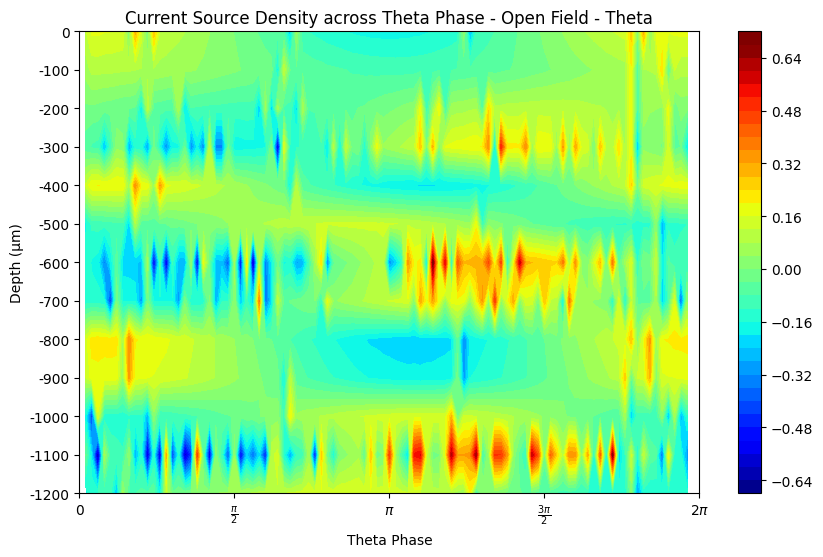

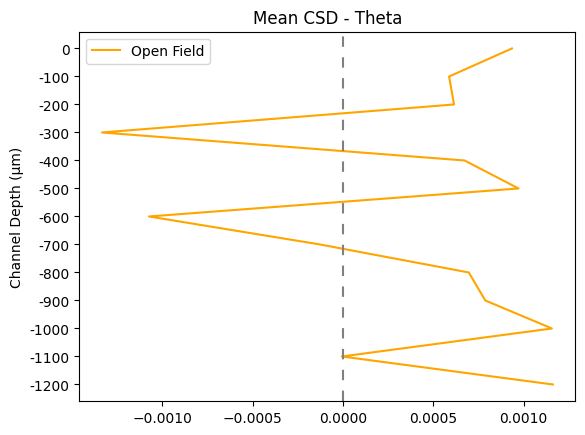

Calculated CSD for trial 230609_r1364_raw_open-field_2


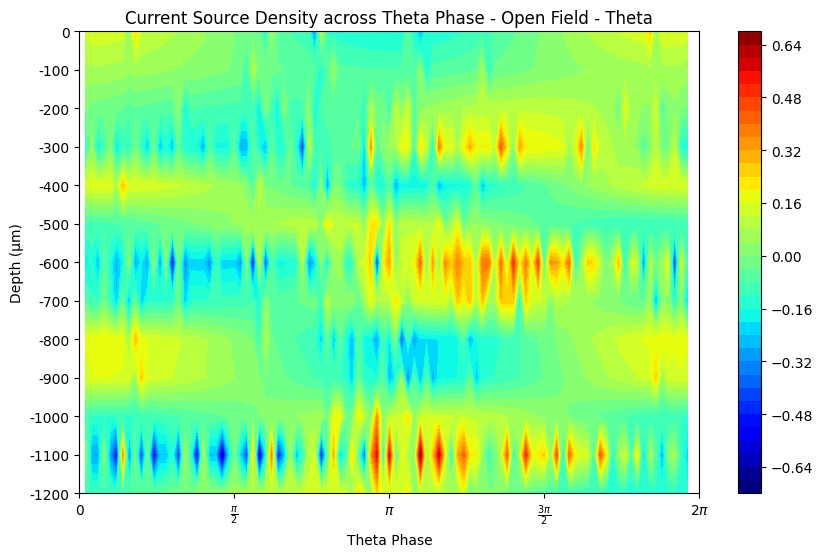

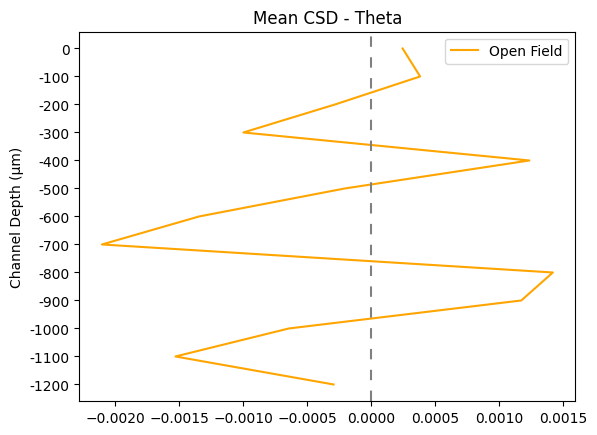

In [ ]:
from analysis.get_traversal_data import drop_extreme_cycles
from analysis.bz_csd import calculate_csd_df, mean_csd_theta_phase, plot_csd_theta_phase
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channel_depths = np.arange(len(channels_to_load)) * -100
figure_dir = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures'

# Load from pickle
df_all_sessions = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_sessions_theta_phase.pkl')

freq_band = [4, 12]
freq_band_name = 'Theta'

# Create dataframes for output
cycle_df = pd.DataFrame(columns=['Theta Cycles']).astype(object)
mean_csd_df = pd.DataFrame()

csds_thata_phase = {}
    
# Loop through sessions
for obj in df_all_sessions.loc[:, 'ephys_object']:
        
    # Loop through open field trials
    for trial_iterator, trial in ((i, t) for i, t in enumerate(obj.trial_list) if 'open-field' in t):
        
        # Set CSD save path
        csd_path = f'{figure_dir}/P{obj.age}_{obj.date_short}_{obj.animal}/CSD'
        # Check if the directory exists, if not, create it
        if not os.path.exists(csd_path):
            os.makedirs(csd_path)

        ## Load relevant lfp data from object
        cycle_numbers = obj.cycle_data[trial_iterator]['cycle_numbers']
        theta_phase = obj.cycle_data[trial_iterator]['theta_phase']
        
        lfp_timestamps = obj.lfp_data[trial_iterator]['timestamps']
        lfp_sampling_rate = obj.lfp_data[trial_iterator]['sampling_rate']


        ## Reload LFP data to include all relevant channels for CSD calculation. This will load 13 channels worth of LFP data, and filter to the specified frequency band
        # This will also write over the calculated metrics stored above
        obj.load_lfp(trial_iterator,
         sampling_rate = lfp_sampling_rate, 
         channels  = channels_to_load, 
         reload_flag = True,
         scale_to_uv = True,
         bandpass_filter = freq_band)

        lfp_data = obj.lfp_data[trial_iterator]['data']

        ## Get speed data and align to LFP timestamps
        obj.load_pos(trial_iterator, reload_flag = False, output_flag = False)
        speed_data = obj.pos_data[trial_iterator]['speed']
        pos_sampling_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
        num_data_points = len(speed_data)

        # Original timestamps at 50 Hz
        original_timestamps = np.linspace(0, num_data_points/pos_sampling_rate, num=num_data_points, endpoint=True)
        # Create interpolation function
        interpolation_function = interp1d(original_timestamps, speed_data, kind='linear')
        # Interpolate to get new data at 1000 Hz
        resampled_speed_data = interpolation_function(lfp_timestamps)

        ## Make dataframe of all lfp data, speed and cycle index
        cycle_df = pd.DataFrame(lfp_data, columns = channels_to_load)
        cycle_df['Cycle Index'] = cycle_numbers
        cycle_df['Cycle Theta Phase'] = theta_phase
        cycle_df['Speed'] = resampled_speed_data

        # Add traversal as zeroes (consider all session a single traversal for open field)
        cycle_df['Traversal Index'] = np.zeros(len(cycle_df.index))

        # Drop rows with NaN cycle indices
        cycle_df = cycle_df.dropna(subset=['Cycle Index'])

        ## Calculate CSD
        csd_df, csd_labels = calculate_csd_df(cycle_df.T)

        # Drop the first and last theta cycle for each traversal to remove calculation artefacts
        csd_df = drop_extreme_cycles(csd_df)

        ## Filter dataframe for speed > 2.5 cm/s
        csd_df = csd_df.loc[:, csd_df.loc['Speed'] > 2.5]


        print(f'Calculated CSD for trial {trial}')

        ## Compute mean CSD vs theta phase
        csd_theta_phase = mean_csd_theta_phase(csd_df, csd_labels)
        csds_thata_phase[trial] = csd_theta_phase # add to dict

        #Plot
        plot_csd_theta_phase(csd_theta_phase, 
                             title = f'Open Field - {freq_band_name}', save_path = f'{csd_path}/{trial}_CSD_Theta_Phase_Open-Field_{freq_band_name}.png')
        
        ## Mean csd for each channel and plot
        mean_csd = csd_df.mean(axis = 1)[csd_labels]
        
        plt.plot(mean_csd.values, mean_csd.index, label = 'Open Field', c = 'orange')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.yticks(mean_csd.index.to_list(), channel_depths)
        plt.ylabel('Channel Depth (μm)')
        plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
        plt.savefig(f'{csd_path}/{trial}_mean_CSD_{freq_band_name}.png')
        plt.title(f'Mean CSD - {freq_band_name}')
        plt.show()
    
        ## Add to dataframe for all sessions
        mean_csd.columns = [trial]
        mean_csd_df = pd.concat([mean_csd_df, mean_csd], axis=1)
        

### Plot mean open field CSD across all sessions

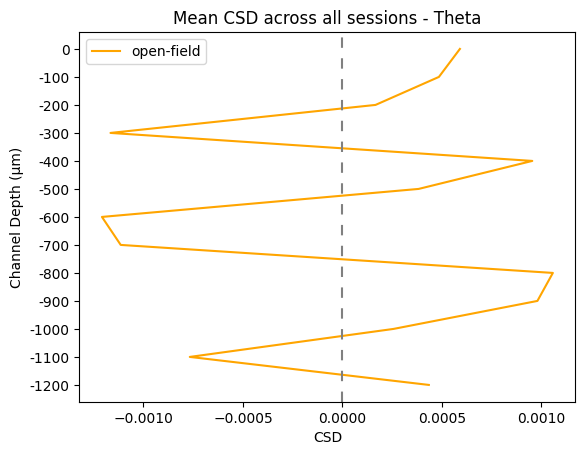

In [9]:
plt.plot(mean_csd_df.mean(axis=1).values, mean_csd_df.mean(axis=1).index, c = 'orange', label = 'open-field')
plt.legend()
plt.gca().invert_yaxis()
plt.yticks(mean_csd_df.mean(axis=1).index.to_list(), channel_depths)
plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
plt.ylabel('Channel Depth (μm)')
plt.xlabel('CSD')
plt.title(f'Mean CSD across all sessions - {freq_band_name}')
plt.savefig(f'{csd_path}/all_trials_mean_CSD_{freq_band_name}.png')
plt.show()

## For each t-maze trial - plot theta phase against frequency power

In [ ]:
from analysis.get_traversal_data import get_traversal_cycles, get_data_for_traversals, drop_extreme_cycles
from analysis.frequency_power import calculate_morlet_df, plot_wavelet_power_spectrum_theta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
# channels_to_load = [35]
figure_dir = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures'

f_min = 30
f_max = 140
f_bins = 100

# Create dataframes for output
cycle_df = pd.DataFrame(columns=['Central Cycles', 'Return Cycles']).astype(object)
# central_mean_csd_df = pd.DataFrame()
# return_mean_csd_df = pd.DataFrame()
    
# Loop through sessions
for obj in df_all_sessions.loc[:, 'ephys_object']:
        
    # Loop through t-maze trials
    for trial_iterator, trial in ((i, t) for i, t in enumerate(obj.trial_list) if 't-maze' in t):
        
        # Set spectrogram save path
        spec_path = f'{figure_dir}/P{obj.age}_{obj.date_short}_{obj.animal}/spectrograms'
        # Check if the directory exists, if not, create it
        if not os.path.exists(spec_path):
            os.makedirs(spec_path)
        
        ## Get central and return arm times from object
        central_times = obj.pos_data[trial_iterator]['central_times']
        return_times = obj.pos_data[trial_iterator]['return_times']

        ## Load relevant lfp data from object
        cycle_numbers = obj.cycle_data[trial_iterator]['cycle_numbers']
        theta_phase = obj.cycle_data[trial_iterator]['theta_phase']
        lfp_timestamps = obj.lfp_data[trial_iterator]['timestamps']
        lfp_sampling_rate = obj.lfp_data[trial_iterator]['sampling_rate']


        # ## Reload LFP data to include all relevant channels for wavelet calculation. This will load 13 channels worth of LFP data 
        # # This will also write over the calculated metrics stored above
        # obj.load_lfp(trial_iterator,
        #  sampling_rate = lfp_sampling_rate, 
        #  channels  = channels_to_load, 
        #  reload_flag = False, ##CAREFUL - CHANGE IF NEEDED
        #  scale_to_uv = True,
        #  bandpass_filter = freq_band)

        lfp_data = obj.lfp_data[trial_iterator]['data']

        ## Get speed data and align to LFP timestamps
        speed_data = obj.pos_data[trial_iterator]['speed']
        pos_sampling_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
        num_data_points = len(speed_data)
        # Original timestamps at 50 Hz
        original_timestamps = np.linspace(0, num_data_points/pos_sampling_rate, num=num_data_points, endpoint=True)
        # Create interpolation function
        interpolation_function = interp1d(original_timestamps, speed_data, kind='linear')
        # Interpolate to get new data at 1000 Hz
        resampled_speed_data = interpolation_function(lfp_timestamps)

        ## Calculate individual arm traversals and get identity of whole theta cycles within each traversal
        central_cycles = get_traversal_cycles(central_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)
        return_cycles = get_traversal_cycles(return_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)

        ## Get lfp trace, theta phase, timestamps, speed, cycle index and traversal index for included individual theta cycles
        central_cycle_df = get_data_for_traversals(central_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)
        return_cycle_df = get_data_for_traversals(return_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)

        ## Loop through each traversal in the dataframe and calculate frequency power, add to dataframe
        # Perform the wavelet transform for each included channel and add to dict
        morlet_dict = {}
        for channel in channels_to_load:
            central_morlet_df = calculate_morlet_df(arm_cycle_df = central_cycle_df,
                                            channel = channel,
                                            lfp_sampling_rate = lfp_sampling_rate,
                                            f_min = f_min,
                                            f_max = f_max,
                                            f_bins = f_bins)
            
            return_morlet_df = calculate_morlet_df(arm_cycle_df = central_cycle_df,
                                            channel = channel,
                                            lfp_sampling_rate = lfp_sampling_rate,
                                            f_min = f_min,
                                            f_max = f_max,
                                            f_bins = f_bins)
            
            # Drop the first and last theta cycle for each traversal to remove calculation artefacts
            central_morlet_df = drop_extreme_cycles(central_morlet_df)
            return_morlet_df = drop_extreme_cycles(return_morlet_df)
            
            ## Filter dataframe for speed > 2.5 cm/s
            central_morlet_df = central_morlet_df.loc[:, central_morlet_df.loc['Speed'] > 2.5]
            return_morlet_df = return_morlet_df.loc[:, return_morlet_df.loc['Speed'] > 2.5]
            
            ## Plot spectrogram for channel
            plot_wavelet_power_spectrum_theta(wavelet_coeffs = central_morlet_df.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).T.values,
                            theta_phase = central_morlet_df.loc(axis = 0)['Cycle Theta Phase'].to_numpy(),
                            n_theta_bins = 100, 
                            frequencies = central_morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list(),
                            arm = 'Central',
                            save_dir = f'{spec_path}/{trial}_morlet_spectrogram_Central.png')
            
            plot_wavelet_power_spectrum_theta(wavelet_coeffs = return_morlet_df.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).T.values,
                            theta_phase = return_morlet_df.loc(axis = 0)['Cycle Theta Phase'].to_numpy(),
                            n_theta_bins = 100, 
                            frequencies = return_morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list(),
                            arm = 'Return',
                            save_dir = f'{spec_path}/{trial}_morlet_spectrogram_Return.png')
            
            
            ## Add calculated wavelet coefficients to dict
            
            
        print(f'Calculated complex morlet wavelet transform for trial {trial}')

#         ## Add to dataframe for all sessions
#         mean_central_csd.columns = [trial]
#         central_mean_csd_df = pd.concat([central_mean_csd_df, mean_central_csd], axis=1)
        
#         mean_return_csd.columns = [trial]
#         return_mean_csd_df = pd.concat([return_mean_csd_df, mean_return_csd], axis=1)


# UNUSED CODE

## Plot theta phase against frequency power for a single trial segment

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import morlet

def complex_morlet_wavelet_transform(signal, frequencies, fs):
    """
    Apply the complex Morlet wavelet transform to a signal for a range of frequencies.

    :param signal: The input signal (time series)
    :param frequencies: Array of frequencies for which to compute the transform
    :param fs: Sampling frequency of the input signal
    :return: An array of wavelet coefficients, time x frequencies
    """
    wavelet_coeffs = np.zeros((len(signal), len(frequencies)), dtype=complex)
    
    # Perform wavelet transform for each frequency
    for i, freq in enumerate(frequencies):
        # Calculate the wavelet for given frequency and sampling frequency
        wavelet = morlet(M=len(signal), w=5, s=freq / fs)
        # Convolve signal with the wavelet
        wavelet_coeffs[:, i] = np.convolve(signal, wavelet, mode='same')
    
    return wavelet_coeffs

def plot_wavelet_power_spectrum(wavelet_coeffs, times, frequencies):
    """
    Plot a time-resolved power spectrum from the wavelet coefficients.

    :param wavelet_coeffs: Wavelet coefficients as returned by complex_morlet_wavelet_transform
    :param times: Array of time points corresponding to the signal
    :param frequencies: Array of frequencies used in the wavelet transform
    """
    power_spectrum = np.abs(wavelet_coeffs) ** 2
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, power_spectrum.T, cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power')
    plt.title('Time-Resolved Power Spectrum')
    plt.tight_layout()
    
    
# Define the frequency range for the analysis
frequencies = np.linspace(1, 150, 100)  # (min_f, max_f, n_bins)
t_min = 50000
t_max = 100000
lfp_data = obj.lfp_data[1]['data'][t_min:t_max]
theta_phase = obj.lfp_data[1]['theta_phase'][t_min:t_max]

# Perform the wavelet transform
wavelet_coeffs = complex_morlet_wavelet_transform(lfp_data[:,0], frequencies, lfp_sampling_rate)

n_bins = 50  # Number of bins for theta phase
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
power_spectra = np.zeros((len(frequencies), n_bins))

for i in range(n_bins):
    # Find indices for the current theta phase bin
    indices = np.where((theta_phase >= bin_edges[i]) & (theta_phase < bin_edges[i + 1]))[0]

    # Extract the wavelet coefficients for these indices
    selected_coeffs = wavelet_coeffs[indices, :]

    # Calculate the average power spectrum for this phase bin
    power_spectra[:, i] = np.mean(np.abs(selected_coeffs) ** 2, axis=0)
    
# Smooth data across phase bins
from scipy.ndimage import gaussian_filter1d
# Apply this to each frequency bin
sigma = 2  # Standard deviation for Gaussian kernel
smoothed_power_spectra = np.array([gaussian_filter1d(power_spectra[i, :], sigma) for i in range(power_spectra.shape[0])])


# Plotting
theta_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.figure(figsize=(10, 6))
plt.pcolormesh(theta_bin_centers, frequencies, smoothed_power_spectra, cmap='jet')
plt.xlabel('Theta Phase [radians]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power')
plt.title('Theta Phase vs Frequency Power Spectrum')

# Adjust the x-axis to show multiples of pi
x_ticks = np.linspace(0, 2 * np.pi, 5)  # 0, pi/2, pi, 3pi/2, 2pi
x_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(x_ticks, x_labels)

# Overlay a theta cycle
theta_cycle = np.cos(np.linspace(0, 2 * np.pi, 100))
theta_phase_values = np.linspace(0, 2 * np.pi, 100)
offset = np.median(frequencies)  # Adjust as per your plot
theta_cycle_normalized = theta_cycle * np.ptp(frequencies)/4 + offset
plt.plot(theta_phase_values, theta_cycle_normalized, color='white', linestyle='--', linewidth=2)

plt.show()

# # Plot the power spectrum
# plot_wavelet_power_spectrum(wavelet_coeffs, obj.lfp_data[1]['timestamps'][t_min:t_max], frequencies)

# plt.plot(obj.lfp_data[1]['timestamps'][t_min:t_max], (filtered_lfp[t_min:t_max]/300)+50, c = 'w')
# plt.show()